In [2]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-04-12 08:19:53.631363: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-12 08:19:53.631471: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-12 08:19:53.789041: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Define the paths to the authentic and tempered image folders
authentic_path = '/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Au'
tempered_path = '/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Tp'
# groundtruth_path = '/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/CASIA 2 Groundtruth'

In [4]:
# Load the authentic and tempered images
authentic_images = [os.path.join(authentic_path, f) for f in os.listdir(authentic_path) if f.endswith('.jpg')]
tempered_images = [os.path.join(tempered_path, f) for f in os.listdir(tempered_path) if f.endswith('.jpg')]
# groundtruth_images = [os.path.join(groundtruth_path, f) for f in os.listdir(groundtruth_path) if f.endswith('.jpg')]


In [5]:
# Create the labels
y_authentic = np.zeros(len(authentic_images))
y_tempered = np.ones(len(tempered_images))
# Combine the images and labels
X = authentic_images + tempered_images
y = np.concatenate((y_authentic, y_tempered))

In [6]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [7]:
# Define the data augmentation parameters
data_augmentation = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

In [8]:
# Preprocess the images
def preprocess_image(img_path, input_shape):
    img = Image.open(img_path)
    img = img.resize(input_shape[:2])
    img = np.array(img) / 255.0  # Normalize the pixel values
    return img

input_shape = (224, 224, 3)
X_train = np.array([preprocess_image(img_path, input_shape) for img_path in X_train])
X_val = np.array([preprocess_image(img_path, input_shape) for img_path in X_val])


In [9]:
# Create the data generator for the training set
train_generator = data_augmentation.flow(X_train, y_train, batch_size=32)

In [10]:
# Define the RDCN model
def create_rdcn_model(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model



In [12]:
# Train the RDCN model
rdcn_model = create_rdcn_model(input_shape)
rdcn_model.fit(train_generator, validation_data=(X_val, y_val), epochs=50, steps_per_epoch=len(X_train) // 32)


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  2/237 ━━━━━━━━━━━━━━━━━━━━ 14s 64ms/step - accuracy: 0.6094 - loss: 0.7817   

I0000 00:00:1712910130.900480      73 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1712910130.917704      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.7633 - loss: 0.5724

W0000 00:00:1712910209.782616      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


237/237 ━━━━━━━━━━━━━━━━━━━━ 97s 345ms/step - accuracy: 0.7633 - loss: 0.5723 - val_accuracy: 0.7833 - val_loss: 0.5146
Epoch 2/50
  1/237 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.7812 - loss: 0.4689

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


237/237 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7812 - loss: 0.4689 - val_accuracy: 0.7833 - val_loss: 0.5169
Epoch 3/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 72s 295ms/step - accuracy: 0.7871 - loss: 0.5246 - val_accuracy: 0.7833 - val_loss: 0.5139
Epoch 4/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6875 - loss: 0.6057 - val_accuracy: 0.7833 - val_loss: 0.5139
Epoch 5/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 73s 298ms/step - accuracy: 0.7849 - loss: 0.5160 - val_accuracy: 0.7833 - val_loss: 0.5233
Epoch 6/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6875 - loss: 0.6275 - val_accuracy: 0.7833 - val_loss: 0.5223
Epoch 7/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 73s 297ms/step - accuracy: 0.7825 - loss: 0.5159 - val_accuracy: 0.7833 - val_loss: 0.5050
Epoch 8/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8438 - loss: 0.4264 - val_accuracy: 0.7833 - val_loss: 0.5041
Epoch 9/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 73s 297ms/step - accuracy: 0.7830 - loss: 0.5125 - val_accuracy: 0

In [17]:
# Evaluate the models
rdcn_loss, rdcn_acc = rdcn_model.evaluate(X_val, y_val)
# mfcn_loss, mfcn_acc = mfcn_model.evaluate(X_val, y_val)

print(f'RDCN Validation Loss: {rdcn_loss:.4f}, Validation Accuracy: {rdcn_acc:.4f}')
# print(f'MFCN Validation Loss: {mfcn_loss:.4f}, Validation Accuracy: {mfcn_acc:.4f}')

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7629 - loss: 0.4437
RDCN Validation Loss: 0.4165, Validation Accuracy: 0.7906


Epoch 1/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 75s 309ms/step - accuracy: 0.7854 - loss: 0.4428 - val_accuracy: 0.7938 - val_loss: 0.4788
Epoch 2/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6250 - loss: 0.5493 - val_accuracy: 0.7938 - val_loss: 0.4705
Epoch 3/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 72s 293ms/step - accuracy: 0.7829 - loss: 0.4419 - val_accuracy: 0.7975 - val_loss: 0.4027
Epoch 4/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8438 - loss: 0.3868 - val_accuracy: 0.7975 - val_loss: 0.4029
Epoch 5/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 72s 295ms/step - accuracy: 0.7882 - loss: 0.4416 - val_accuracy: 0.7933 - val_loss: 0.4021
Epoch 6/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8125 - loss: 0.3479 - val_accuracy: 0.7927 - val_loss: 0.4018
Epoch 7/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 72s 295ms/step - accuracy: 0.7873 - loss: 0.4292 - val_accuracy: 0.7954 - val_loss: 0.4242
Epoch 8/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6562 - loss: 0.6101 - val_

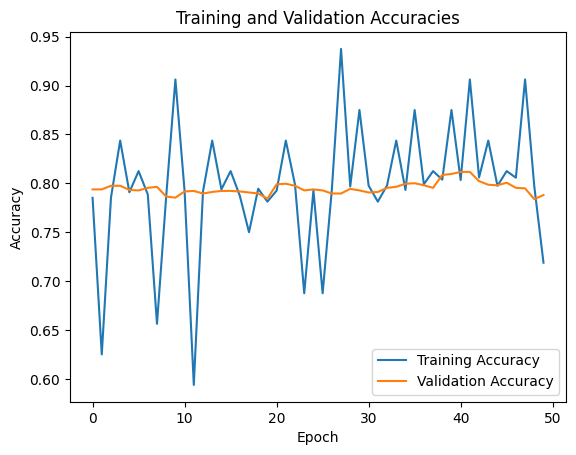

  1/238 ━━━━━━━━━━━━━━━━━━━━ 3:21 848ms/step - accuracy: 0.7500 - loss: 0.3269

W0000 00:00:1712913822.206662      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


238/238 ━━━━━━━━━━━━━━━━━━━━ 70s 293ms/step - accuracy: 0.8055 - loss: 0.3740
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7707 - loss: 0.4114
RDCN Training Loss: 0.3703, Training Accuracy: 0.8095
RDCN Validation Loss: 0.4008, Validation Accuracy: 0.7880


In [18]:
import matplotlib.pyplot as plt

# Train the RDCN model
history = rdcn_model.fit(train_generator, validation_data=(X_val, y_val), epochs=50, steps_per_epoch=len(X_train) // 32)

# Plot training and validation accuracies
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracies')
plt.legend()
plt.show()

# Evaluate the RDCN model
rdcn_train_loss, rdcn_train_acc = rdcn_model.evaluate(train_generator)
rdcn_val_loss, rdcn_val_acc = rdcn_model.evaluate(X_val, y_val)

print(f'RDCN Training Loss: {rdcn_train_loss:.4f}, Training Accuracy: {rdcn_train_acc:.4f}')
print(f'RDCN Validation Loss: {rdcn_val_loss:.4f}, Validation Accuracy: {rdcn_val_acc:.4f}')
